In [1]:
# Necessary imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import argparse

from torch import Tensor

from qiskit import Aer, QuantumCircuit, BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.multiclass_extensions import AllPairs
from qiskit.aqua.utils.dataset_helper import get_feature_dimension

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from quantic.data import DatasetLoader
    
# Additional torch-related imports
from torch import no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim # Adam, SGD, LBFGS
from torch.nn import NLLLoss # CrossEntropyLoss, MSELoss, L1Loss, BCELoss
from qnetworks import HybridQNN_Shallow
from qnetworks import HybridQNN

#time
import timeit


In [2]:
# network args
n_classes = 2
n_qubits = 2
n_features = None
if n_features is None:
    n_features = n_qubits
network = "hybridqnn_shallow" #hybridqnn_shallow
# train args
batch_size = 2
epochs = 10
LR = 0.001
n_samples_train = 100 #128
n_samples_test = 50 #64
# plot args
n_samples_show = batch_size
# dataset args
shuffle = True
dataset = "MNIST" # CIFAR10 / CIFAR100, any from pytorch
dataset_cfg = ""
specific_classes_names = ['0','1'] # selected (filtered) classes
print(specific_classes_names)
use_specific_classes = len(specific_classes_names)>=n_classes
# preprocessing
input_resolution = (28,28) #(28,28) # please check n_filts required on fc1/fc2 to input to qnn
resize_interpolation = transforms.functional.InterpolationMode.BILINEAR 

# Set seed for random generators
rand_seed = np.random.randint(50)
algorithm_globals.random_seed = rand_seed
manual_seed(rand_seed) # Set train shuffle seed (for reproducibility)

if not os.path.exists("plots"):
    os.mkdir("plots")

['0', '1']


In [3]:


######## PREPARE DATASETS
time_start = timeit.timeit()

# Train Dataset
# -------------

if dataset_cfg:
    # Load a dataset configuration file
    dataset = DatasetLoader.load(from_cfg=dataset_cfg,framework='torchvision')
else:
    # Or instantate dataset manually
    dataset = DatasetLoader.load(dataset_type=dataset,
                                   num_classes=n_classes,
                                   specific_classes=specific_classes_names,
                                   num_samples_class_train=n_samples_train,
                                   num_samples_class_test=n_samples_test,
                                   framework='torchvision'
                                   )
print(f'Dataset partitions: {dataset.get_partitions()}')

X_train = dataset['train']
X_test = dataset['test']


# Get channels (rgb or grayscale)
if len(X_train.data.shape)>3: # 3d image (rgb+)
    n_channels = X_train.data.shape[3]
else: # 2d image (grayscale)
    n_channels = 1

if network == 'hybridqnn_shallow' or network == 'QSVM':
    # Set preprocessing transforms
    list_preprocessing = [
        transforms.Resize(input_resolution),
        transforms.ToTensor(),
    ] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
else:
    list_preprocessing = [
        transforms.Resize(input_resolution),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    ] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
X_train.transform= transforms.Compose(list_preprocessing)
X_test.transform = transforms.Compose(list_preprocessing)           

# set filtered/specific class names
classes_str = ",".join(dataset.specific_classes_names)
classes2spec = {}
specific_classes = dataset.specific_classes
for idx, class_idx in enumerate(specific_classes):
    classes2spec[class_idx]=idx

classes_list = dataset.classes
n_samples = n_samples_test

Dataset partitions: ['train', 'test']


In [4]:
# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=shuffle)
# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=shuffle)

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Dataloaders elapsed time: {time_elapsed} s")

Dataloaders elapsed time: 0.00096525700064376 s


<Figure size 432x288 with 0 Axes>

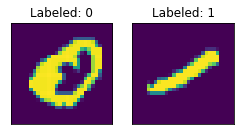

<Figure size 432x288 with 0 Axes>

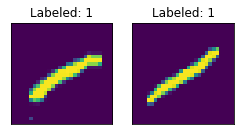

In [5]:
##### VISUALIZE LABELS
data_iter = iter(train_loader)
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    try:
        images, targets = data_iter.__next__()
    except:
        break
    plt.clf()
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for idx, image in enumerate(images):
        axes[idx].imshow(np.moveaxis(images[idx].numpy().squeeze(),0,-1))
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        class_label = classes_list[targets[idx].item()]
        axes[idx].set_title("Labeled: {}".format(class_label))
        if idx > n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_labeled_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            break
    plt.show()
    n_samples_show_alt -= 1
    

In [6]:
##### DESIGN NETWORK
time_start = timeit.timeit()



# init network
if network == "hybridqnn_shallow":
    ## predefine number of input filters to fc1 and fc2
    # examples: 13456 for (128x128x1), 59536 for (256x256x1), 256 for (28x28x1), 400 for (28x28x3) or (35x35x1) 
    if n_channels == 1:
        n_filts_fc1 = int(((((input_resolution[0]-4)/2)-4)/2)**2)*16
    else:
        n_filts_fc1 = int(((((input_resolution[0]+7-4)/2)-4)/2)**2)*16
    n_filts_fc2 = int(n_filts_fc1 / 4)

    # declare quantum instance
    qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
    # Define QNN
    feature_map = ZZFeatureMap(n_features)
    ansatz = RealAmplitudes(n_qubits, reps=1)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = TwoLayerQNN(
        n_qubits, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi
    )
    print(qnn.operator)
    qnn.circuit.draw(output="mpl",filename=f"plots/qnn{n_qubits}_{n_classes}classes.png")
    #from qiskit.quantum_info import Statevector
    #from qiskit.visualization import plot_bloch_multivector
    #state = Statevector.from_instruction(qnn.circuit)
    #plot_bloch_multivector(state)
    model = HybridQNN_Shallow(n_classes = n_classes, n_qubits = n_qubits, n_channels = n_channels, n_filts_fc1 = n_filts_fc1, n_filts_fc2 = n_filts_fc2, qnn = qnn)
    print(model)

    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_func = NLLLoss()

elif network == "QSVM":
    backend = BasicAer.get_backend('qasm_simulator')

    # todo: fix this transformation for QSVM
    train_input = X_train.targets
    test_input = X_test.targets
    total_array = np.concatenate([test_input[k] for k in test_input])
    #
    feature_map = ZZFeatureMap(feature_dimension=get_feature_dimension(train_input),
                               reps=2, entanglement='linear')
    svm = QSVM(feature_map, train_input, test_input, total_array,
               multiclass_extension=AllPairs())
    quantum_instance = QuantumInstance(backend, shots=1024,
                                       seed_simulator=algorithm_globals.random_seed,
                                       seed_transpiler=algorithm_globals.random_seed)
else:
    model = HybridQNN(backbone=network,pretrained=True,n_qubits=n_qubits,n_classes=n_classes)
    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.network.parameters(), lr=LR)
    loss_func = NLLLoss()
    
time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Network init elapsed time: {time_elapsed} s")

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])
HybridQNN_Shallow(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)
Network init elapsed time: -0.004744197998661548 s


Batch 0, Loss: -0.5855482816696167
Batch 1, Loss: -0.6264811754226685
Batch 2, Loss: -0.447964608669281
Batch 3, Loss: -0.6887856721878052
Batch 4, Loss: -0.6666295528411865
Batch 5, Loss: -0.5564414858818054
Batch 6, Loss: -0.5875259637832642
Batch 7, Loss: -0.47940585017204285
Batch 8, Loss: -0.8505805730819702
Batch 9, Loss: -0.27159106731414795
Batch 10, Loss: -0.8099122047424316
Batch 11, Loss: -0.1333482563495636
Batch 12, Loss: -0.5400454998016357
Batch 13, Loss: -0.5060176849365234
Batch 14, Loss: -0.5056136250495911
Batch 15, Loss: -0.5984381437301636
Batch 16, Loss: -0.20317748188972473
Batch 17, Loss: -0.27078670263290405
Batch 18, Loss: -0.49193379282951355
Batch 19, Loss: -0.6603018045425415
Batch 20, Loss: -0.21019399166107178
Batch 21, Loss: -0.5801764726638794
Batch 22, Loss: -0.3821413516998291
Batch 23, Loss: -0.4952358603477478
Batch 24, Loss: -0.6095492839813232
Batch 25, Loss: -0.5359004139900208
Batch 26, Loss: -0.4844483435153961
Batch 27, Loss: -0.65995925664901

Batch 27, Loss: -0.8265467286109924
Batch 28, Loss: -0.8746054172515869
Batch 29, Loss: -0.809795618057251
Batch 30, Loss: -0.731360673904419
Batch 31, Loss: -0.7747328281402588
Batch 32, Loss: -0.7448090314865112
Batch 33, Loss: -0.7223209738731384
Batch 34, Loss: -0.7245961427688599
Batch 35, Loss: -0.9376828670501709
Batch 36, Loss: -0.8389705419540405
Batch 37, Loss: -0.9270395040512085
Batch 38, Loss: -0.8366602659225464
Batch 39, Loss: -0.8948414921760559
Batch 40, Loss: -0.8963310718536377
Batch 41, Loss: -0.936529815196991
Batch 42, Loss: -0.6373792886734009
Batch 43, Loss: -0.8000602722167969
Batch 44, Loss: -0.7671064734458923
Batch 45, Loss: -0.650383472442627
Batch 46, Loss: -0.991895318031311
Batch 47, Loss: -1.0361988544464111
Batch 48, Loss: -0.9929186105728149
Batch 49, Loss: -0.8043723106384277
Batch 50, Loss: -0.8779894113540649
Batch 51, Loss: -0.8913369178771973
Batch 52, Loss: -0.9783854484558105
Batch 53, Loss: -0.901833176612854
Batch 54, Loss: -0.814654946327209

Batch 55, Loss: -1.0218830108642578
Batch 56, Loss: -1.184117317199707
Batch 57, Loss: -1.1400561332702637
Batch 58, Loss: -1.204148292541504
Batch 59, Loss: -1.3559372425079346
Batch 60, Loss: -1.1292610168457031
Batch 61, Loss: -1.1880909204483032
Batch 62, Loss: -1.0893408060073853
Batch 63, Loss: -1.2844276428222656
Batch 64, Loss: -1.1955363750457764
Batch 65, Loss: -0.9680509567260742
Batch 66, Loss: -1.270398736000061
Batch 67, Loss: -1.2136231660842896
Batch 68, Loss: -1.4127497673034668
Batch 69, Loss: -0.5894584059715271
Batch 70, Loss: -1.2408497333526611
Batch 71, Loss: -1.0258055925369263
Batch 72, Loss: -1.1553860902786255
Batch 73, Loss: -1.3793036937713623
Batch 74, Loss: -1.2878403663635254
Batch 75, Loss: -1.279905915260315
Batch 76, Loss: -1.3725759983062744
Batch 77, Loss: -1.4896330833435059
Batch 78, Loss: -1.3086425065994263
Batch 79, Loss: -1.3041605949401855
Batch 80, Loss: -1.3116497993469238
Batch 81, Loss: -1.3700076341629028
Batch 82, Loss: -1.1106259822845

Batch 83, Loss: -1.498187780380249
Batch 84, Loss: -1.4522933959960938
Batch 85, Loss: -1.6947277784347534
Batch 86, Loss: -1.4803457260131836
Batch 87, Loss: -1.2995810508728027
Batch 88, Loss: -1.6314681768417358
Batch 89, Loss: -1.554149866104126
Batch 90, Loss: -1.5821714401245117
Batch 91, Loss: -1.650634765625
Batch 92, Loss: -1.6308045387268066
Batch 93, Loss: -1.8149316310882568
Batch 94, Loss: -1.5086324214935303
Batch 95, Loss: -1.707378625869751
Batch 96, Loss: -1.2762235403060913
Batch 97, Loss: -1.7420700788497925
Batch 98, Loss: -1.6965335607528687
Batch 99, Loss: -1.7854520082473755
Training [70%]	Loss: -1.5261
Batch 0, Loss: -1.1476043462753296
Batch 1, Loss: -0.5879133939743042
Batch 2, Loss: -1.6786433458328247
Batch 3, Loss: -1.7417535781860352
Batch 4, Loss: -1.7440073490142822
Batch 5, Loss: -1.7936731576919556
Batch 6, Loss: -1.788763165473938
Batch 7, Loss: -1.7942016124725342
Batch 8, Loss: -1.6891405582427979
Batch 9, Loss: -1.7883400917053223
Batch 10, Loss: -

Batch 11, Loss: -1.869231939315796
Batch 12, Loss: -2.1126976013183594
Batch 13, Loss: -2.1073803901672363
Batch 14, Loss: -1.5701584815979004
Batch 15, Loss: -2.120431900024414
Batch 16, Loss: -2.1068170070648193
Batch 17, Loss: -1.970274806022644
Batch 18, Loss: -2.057112693786621
Batch 19, Loss: -2.046637535095215
Batch 20, Loss: -2.087515354156494
Batch 21, Loss: -1.7961926460266113
Batch 22, Loss: -1.7582565546035767
Batch 23, Loss: -1.9496395587921143
Batch 24, Loss: -1.7394492626190186
Batch 25, Loss: -2.0501046180725098
Batch 26, Loss: -2.087566375732422
Batch 27, Loss: -2.1203203201293945
Batch 28, Loss: -2.1336569786071777
Batch 29, Loss: -1.9513134956359863
Batch 30, Loss: -1.855086326599121
Batch 31, Loss: -2.0360488891601562
Batch 32, Loss: -2.083221435546875
Batch 33, Loss: -2.0366501808166504
Batch 34, Loss: -1.85807466506958
Batch 35, Loss: -2.0718228816986084
Batch 36, Loss: -2.030879497528076
Batch 37, Loss: -2.0563926696777344
Batch 38, Loss: -2.0384421348571777
Batc

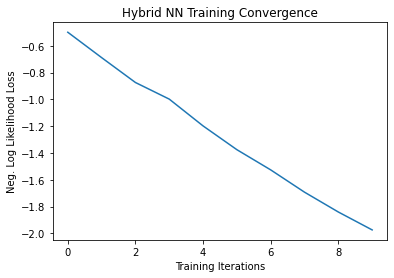

Training time: -0.005425075942184776 s


In [7]:
################# TRAIN
# Start training
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.train()  # Set model to training mode
    if network == "hybridqnn_shallow":
        model.train()  # Set model to training mode
        
    loss_list = []  # Store loss history
    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad(set_to_none=True)  # Initialize gradient
            output = model(data)  # Forward pass

            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            loss = loss_func(output, target)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            total_loss.append(loss.item())  # Store loss
            print(f"Batch {batch_idx}, Loss: {total_loss[-1]}")
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

    # Plot loss convergence
    plt.clf()
    plt.plot(loss_list)
    plt.title("Hybrid NN Training Convergence")
    plt.xlabel("Training Iterations")
    plt.ylabel("Neg. Log Likelihood Loss")
    #plt.savefig(f"plots/{dataset}_classification{classes_str}_hybridqnn_q{n_qubits}_{n_samples}samples_lr{LR}_bsize{batch_size}.png")
    plt.show()
    
elif network == "QSVM":
    result = svm.run(quantum_instance)
    for k,v in result.items():
        print(f'{k} : {v}')

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Training time: {time_elapsed} s")

In [8]:
######## TEST
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.eval()  # Set model to eval mode
    if network == "hybridqnn_shallow":
        model.eval()  # Set model to eval mode
    with no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)
            pred = output.argmax(dim=1, keepdim=True)

            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target)
            total_loss.append(loss.item())

        print(
            "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
                sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
            )
        )

    time_end = timeit.timeit()
    time_elapsed = time_end - time_start
    print(f"Test time: {time_elapsed} s")
    
    


Performance on test data:
	Loss: -2.0383
	Accuracy: 100.0%
Test time: 0.0002368820714764297 s


<Figure size 432x288 with 0 Axes>

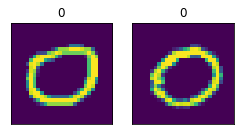

<Figure size 432x288 with 0 Axes>

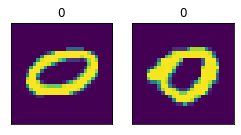

In [9]:
# Plot predicted labels
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    plt.clf()
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for batch_idx, (data, target) in enumerate(test_loader):    
        if count == n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_pred_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            plt.show()
            break
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        for sample_idx in range(batch_size):
            try:
                class_label = classes_list[specific_classes[pred[sample_idx].item()]]
            except:
                class_label = classes_list[specific_classes[pred[sample_idx].item()-1]]
            axes[count].imshow(np.moveaxis(data[sample_idx].numpy().squeeze(),0,-1))
            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title(class_label)
            count += 1
    n_samples_show_alt -= 1

### 